In [1]:
# imports
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.neighbors import LocalOutlierFactor

from pulp import *

from scipy.optimize import curve_fit

In [2]:
def preprocess(): 
    df = pd.read_csv('bq-results-20210621-161457-6hfonvl5yvcp.csv')
    df = df.astype({'Date':np.datetime64})
    df['week'] = df['Date'].dt.isocalendar().week
    df['year'] = df['Date'].dt.year
    df['Cost'] = df.DoubleClickCost + df.SEMCost + df.ClickcastCost + df.TMPProgrammaticCost
    df = df[df['Cost'] > 0]
    df = df.drop(['DoubleClickCost', 'SEMCost', 'ClickcastCost', 'TMPProgrammaticCost'], axis = 1)
    #outliers
    #data from 2020
    #df = df[df.date >= '2020-01-01']
    #data from the relevant channels
    df = df[df.isin({'PlacementType': ['Display', 
                                       'Email', 
                                       'Job Posting', 
                                       'Other', 
                                       'Paid Search', 
                                       'Profile', 
                                       'Programmatic Jobs', 
                                       'Social']})['PlacementType']]
    df = df.groupby(['PlacementType','year','week']).sum().reset_index()
    return df

In [3]:
def objective(x, a, b, c, d):
    return a * np.sqrt(x) + b * np.log(x) + c * x + d

In [4]:
def plot_function(df):
    #the concave function parameters for each channel
    objective_values = {}
    for chan in np.unique(df.PlacementType):
        if (chan not in ['Profile']): #'Job Posting'
            print(chan)
            sub_df = df[df.PlacementType == chan]
            x = sub_df.Cost
            y = sub_df.Apps
            plt.hist(x)
            plt.show()
            plt.figure(figsize = (5,5))
            plt.scatter(x, y, label = 'actual')
            popt, _ = curve_fit(objective, x, y, bounds=([0, 0, 0, 0],[10E9,10E9,10E9,10E9])) # [np.inf,np.inf,np.inf,np.inf]
            a, b, c, d = popt
            objective_values[chan] = {'a':a, 'b':b, 'c':c, 'd':d}
            print('y = %.5f * sqrt(x) + %.5f * log(x) + %.5f * x + %.5f' % (a, b, c, d))
            print('RMSE', np.sqrt(np.mean((objective(x, a, b, c, d) - y)**2)))
            x_line = np.arange(1, max(x), 1)
            # calculate the output for the range
            y_line = objective(x_line, a, b, c, d)
            # create a line plot for the mapping function
            plt.plot(x_line, y_line, '--', color='red', label = chan)
            plt.legend()
            plt.show()
    return objective_values

In [5]:
def calc_slope(df, budget, objective_values):
    allocation = {}    
    slopes = {}
    for chan in np.unique(df.PlacementType):
        slopes[chan] = {}
        allocation[chan] = 0
        for i in range(budget):
            slopes[chan][i] = objective(i+1, 
                                        objective_values[chan]['a'], 
                                        objective_values[chan]['b'], 
                                        objective_values[chan]['c'], 
                                        objective_values[chan]['d']) - objective(i,
                                                                                 objective_values[chan]['a'],
                                                                                 objective_values[chan]['b'],
                                                                                 objective_values[chan]['c'],
                                                                                 objective_values[chan]['d'])
    return slopes, allocation

In [6]:
def budget_allocation(df, budget, slopes, allocation):
    for i in range(budget):
        maxi = 0
        picked_chan = None
        for chan in np.unique(df.PlacementType):
            if slopes[chan][allocation[chan]] > maxi: 
                maxi = slopes[chan][allocation[chan]]
                picked_chan = chan
            else: 
                continue
        allocation[picked_chan] += 1
    allocation = {k: v / budget for k, v in allocation.items()}
    return allocation

In [7]:
def main(budget): 
    df = preprocess()
    objective_values = plot_function(df)
#     slopes, allocation = calc_slope(df, budget, objective_values)
#     allocation = budget_allocation(df, budget, slopes, allocation)
#     return allocation

In [8]:
df = preprocess()

Display


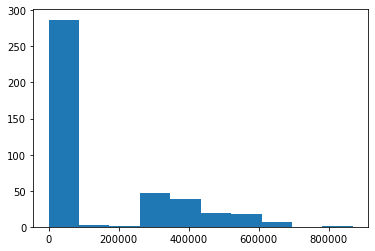

y = 18.88775 * sqrt(x) + 0.00000 * log(x) + 0.00000 * x + 0.00000
RMSE 2024.9516653123387


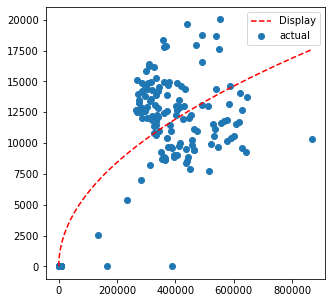

Email


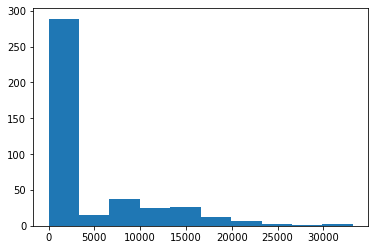

y = 0.60065 * sqrt(x) + 0.00000 * log(x) + 0.00904 * x + 0.00000
RMSE 84.9752703207055


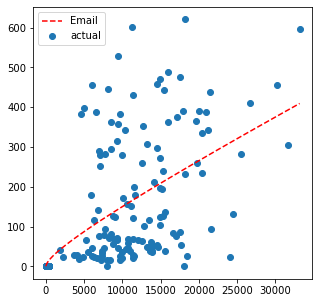

Job Posting


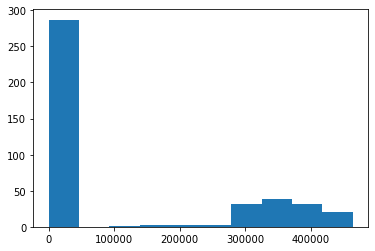

y = 121.31402 * sqrt(x) + 0.00000 * log(x) + 0.00000 * x + 0.00000
RMSE 14903.543054490954


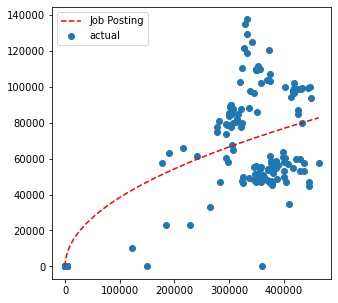

Other


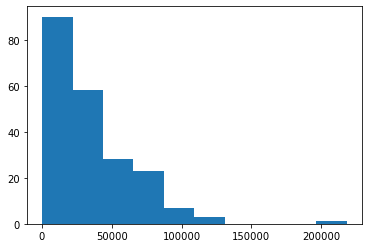

y = 1.94913 * sqrt(x) + 13.86501 * log(x) + 0.00000 * x + 0.00000
RMSE 328.4647016182446


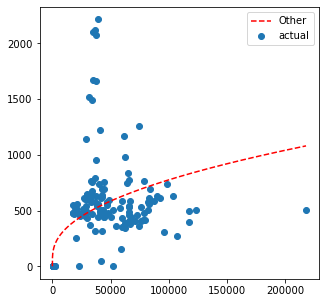

Paid Search


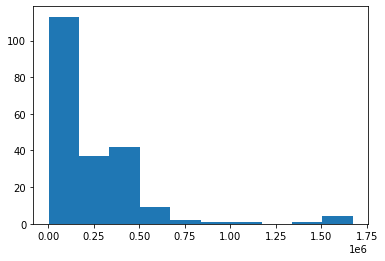

y = 44.31222 * sqrt(x) + 0.00000 * log(x) + 0.00000 * x + 0.00000
RMSE 3984.288012391905


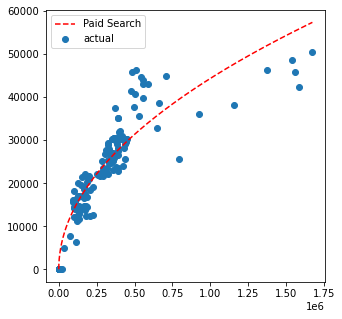

Programmatic Jobs


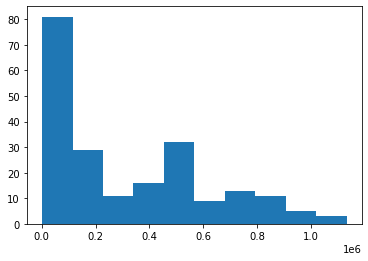

y = 27.63965 * sqrt(x) + 0.00000 * log(x) + 0.02053 * x + 0.00000
RMSE 8448.080697108082


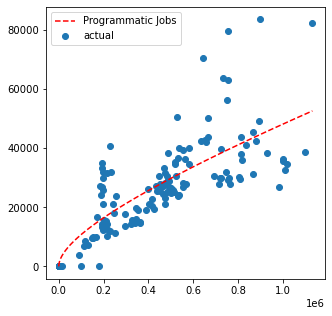

Social


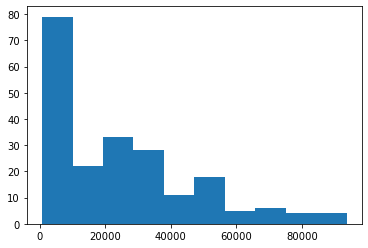

y = 1.37144 * sqrt(x) + 0.71259 * log(x) + 0.00000 * x + 0.00000
RMSE 146.9198289658357


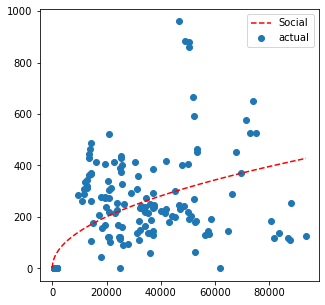

In [9]:
objective_values = plot_function(df)

In [10]:
objective_values

{'Display': {'a': 18.88775276253403,
  'b': 6.778676549186702e-10,
  'c': 1.0225451765960579e-12,
  'd': 1.2467782810589467e-08},
 'Email': {'a': 0.6006495699223693,
  'b': 6.424901061648611e-09,
  'c': 0.009036880533629704,
  'd': 4.641549147325448e-12},
 'Job Posting': {'a': 121.3140190657284,
  'b': 8.345362912900308e-16,
  'c': 5.089309487086537e-11,
  'd': 2.31871340399697e-16},
 'Other': {'a': 1.9491323207999605,
  'b': 13.865011036161295,
  'c': 8.139037296036015e-20,
  'd': 1.717796904248425e-14},
 'Paid Search': {'a': 44.312223632619,
  'b': 1.3401931474950807e-10,
  'c': 2.9333483749849376e-13,
  'd': 4.00686298670532e-13},
 'Programmatic Jobs': {'a': 27.639645201031378,
  'b': 3.615726302049338e-08,
  'c': 0.020530929313518777,
  'd': 1.6039922207508366e-08},
 'Social': {'a': 1.3714435152115685,
  'b': 0.7125875861768013,
  'c': 3.829981605186904e-13,
  'd': 2.435234855064815e-08}}

In [11]:
a_list = []
b_list = []
c_list = []
d_list = []
for key in objective_values.keys():
    print(key)
    a_list.append(objective_values[key]['a'])
    b_list.append(objective_values[key]['b'])
    c_list.append(objective_values[key]['c'])
    d_list.append(objective_values[key]['d'])

Display
Email
Job Posting
Other
Paid Search
Programmatic Jobs
Social


In [13]:
a_list

[18.88775276253403,
 0.6006495699223693,
 121.3140190657284,
 1.9491323207999605,
 44.312223632619,
 27.639645201031378,
 1.3714435152115685]

In [14]:
df['cpa'] = np.NaN
the_loc = df['Apps'] > 0
df.loc[the_loc,'cpa'] = df.loc[the_loc,'Cost'] / df.loc[the_loc,'Apps']
cpa_min = df['cpa'].min()
cpa_max = df['cpa'].max()
cost_min = df['Cost'].min()
cost_max = df['Cost'].max()
apps_min = df['Apps'].min()
apps_max = df['Apps'].max()
print(f'cpa min: {cpa_min}')
print(f'cpa min: {cpa_max}')

cpa min: 2.4242671116525756
cpa min: 1001.8487250000002


In [15]:
df.describe()

year         week      TenantID    CampaignID           Apps  \
count  2307.000000  2307.000000  2.307000e+03  2.307000e+03    2307.000000   
mean   2021.589077    26.718249  2.116567e+06  8.132437e+09    8301.085392   
std       2.103403    15.140350  3.248656e+06  1.183611e+10   19495.529117   
min    2019.000000     1.000000  8.190000e+02  4.421122e+07       0.000000   
25%    2020.000000    14.000000  4.078200e+04  2.350292e+08       0.000000   
50%    2021.000000    27.000000  2.230620e+05  7.575146e+08       0.000000   
75%    2023.000000    40.000000  3.289878e+06  1.181124e+10    6344.000000   
max    2026.000000    53.000000  1.505958e+07  4.759306e+10  137441.000000   

               Cost          cpa  
count  2.307000e+03  1040.000000  
mean   1.027935e+05    65.842248  
std    1.923664e+05   109.496685  
min    9.476000e-01     2.424267  
25%    2.173710e+01    12.393118  
50%    2.402302e+03    23.051880  
75%    9.984451e+04    65.537323  
max    1.673880e+06  1001.848725

In [16]:
objective_values

{'Display': {'a': 18.88775276253403,
  'b': 6.778676549186702e-10,
  'c': 1.0225451765960579e-12,
  'd': 1.2467782810589467e-08},
 'Email': {'a': 0.6006495699223693,
  'b': 6.424901061648611e-09,
  'c': 0.009036880533629704,
  'd': 4.641549147325448e-12},
 'Job Posting': {'a': 121.3140190657284,
  'b': 8.345362912900308e-16,
  'c': 5.089309487086537e-11,
  'd': 2.31871340399697e-16},
 'Other': {'a': 1.9491323207999605,
  'b': 13.865011036161295,
  'c': 8.139037296036015e-20,
  'd': 1.717796904248425e-14},
 'Paid Search': {'a': 44.312223632619,
  'b': 1.3401931474950807e-10,
  'c': 2.9333483749849376e-13,
  'd': 4.00686298670532e-13},
 'Programmatic Jobs': {'a': 27.639645201031378,
  'b': 3.615726302049338e-08,
  'c': 0.020530929313518777,
  'd': 1.6039922207508366e-08},
 'Social': {'a': 1.3714435152115685,
  'b': 0.7125875861768013,
  'c': 3.829981605186904e-13,
  'd': 2.435234855064815e-08}}

In [173]:
def cpa_to_cost_apps(cpa = None, a = None, 
                     b = None, c = None, d = None, 
                     cost_min = cost_min, cost_max = cost_max, tol = 1E-16, max_iter=1000):

    apps_min = objective(cost_min, a, b, c, d)
    apps_max = objective(cost_max, a, b, c, d)
    
    #print(apps_min, apps_max)
    #print(cost_min / apps_min)
    #print(cost_max / apps_max)
    
    if cost_min / apps_min > cost_max / apps_max:
        print('Warning decreasing Cost vs CPA function')
    else:
        lower_bound = cost_min
        upper_bound = cost_max
        
    # Cannot use inputted CPA
    if (cpa < cost_min / apps_min) | (cpa > cost_max / apps_max):
#        print(f'apss_min {apps_min} cost_min {cost_min} apps_max {apps_max} cost_max {cost_max}')
        return [0,0]

#     display(cost_min / apps_min)
#     display(cost_max / apps_max)

    
    
    for k in range(0,max_iter):
        cost = (lower_bound + upper_bound) / 2
        apps = objective(cost, a, b, c, d)
        if apps == 0:
            print(f'!!!!!!!!!!! arguements to test cost, a, b, c, d {[cost, a, b, c, d]})')
        cur_cpa = cost / apps
        if abs(cur_cpa - cpa) < tol:
            break
        elif cur_cpa > cpa:
            upper_bound = cost
        else:
            lower_bound = cost
#     if k == max_iter - 1:
#         print('Warning: need more iterations for cpa_to_cost_apps')
#         print('Inputs:')
#         display([cpa,a,b,c,d])
#         5/0
    return([cost,apps])

In [ ]:
a = 44.312223632619
b = 1.3401931474950807e-10
c = 2.9333483749849376e-13
d = 4.00686298670532e-13

In [60]:
a = 27.639645201031378
b = 3.61572630204933
c = 0.020530929313518777
d = 1.6039922207508366e-08

0.6169287793745525 0.3976734138335475 0.4962826351946116 0.22686818510773932


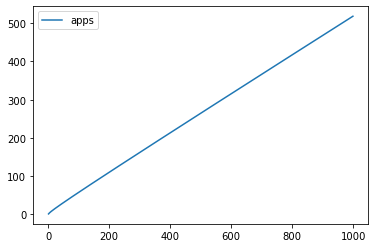

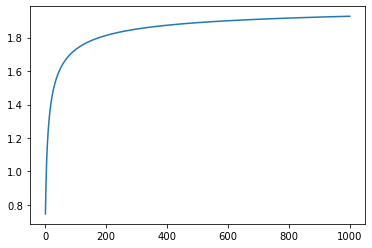

In [163]:
a = np.random.random()
b = np.random.random()
c = np.random.random()
d = np.random.random()

print(a,b,c,d)

x = np.arange(1,1000,1) 
y = objective(x, a, b, c, d)
cpa = x/y
plt.plot(x,y,label = 'apps')
plt.legend()
plt.show()
plt.plot(x,cpa, label = 'cpa')
plt.show()

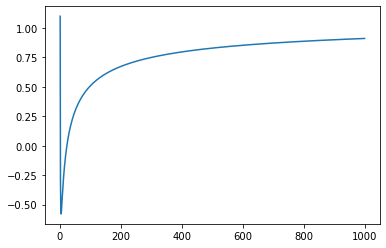

In [71]:
test = objective_dev(x,popt[0], popt[1], popt[2])
plt.plot(x,test)
plt.show()

In [54]:
def objective_dev(x,a,b,c):
    return a * 0.5 * (1/np.sqrt(x)) + b * (1/x) + c 

In [55]:
popt, _ = curve_fit(objective_dev, x, cpa)

In [58]:
popt[0]

-13.533905527714237

In [164]:
a = objective_values['Display']['a']
b = objective_values['Display']['b']
c = objective_values['Display']['c']
d = objective_values['Display']['d']

cpa_to_cost_apps(cpa = 20, a = a, b = b, c = c, d = d, cost_min = cost_min, 
                 cost_max = cost_max, tol = 1E-16, max_iter=10000)

0.600547779220536 798.1732444174926
1.5778927718788847
2097.138451466748


[152.24044816943226, 7.612022408471613]

In [168]:
a = objective_values['Display']['a']
b = objective_values['Display']['b']
c = objective_values['Display']['c']
d = objective_values['Display']['d']

cpa_to_cost_apps(cpa = 5, a = a, b = b, c = c, d = d, 
                 cost_min = 1E-16, cost_max = 10000, tol = 1E-16, max_iter=10000)

1.763717431201128e-07 1888.7752762823397
5.669842471982483e-10
5.294436096009746


[8918.680110742833, 1783.7360221485667]

In [17]:
print(cost_max)

1673879.8017998904


In [169]:
# Sum objective functions over CPA
def cpa_solver(total_cost = None, a_list = a_list, b_list = b_list, c_list = c_list, d_list = d_list, 
               dict_keys = list(objective_values.keys()), 
            cpa_min = cpa_min, cpa_max = cpa_max, cost_min = cost_min, cost_max = cost_max, 
               cpa_tol = 1E-16, cost_tol = 1E-16, max_iter = 1000, cost_apps_max_iter = 1000):
    # Returns Costs and Apps for all channels for given CPA
    out_dict = {}    
    cpa_lower_bound = cpa_min
    cpa_upper_bound = cpa_max
    print('inital bounds')
    display(cpa_lower_bound)
    display(cpa_upper_bound)
    
    for j in range(0,max_iter):
        cur_cpa = (cpa_upper_bound + cpa_lower_bound) / 2
        cur_total_cost = 0
# Uncomment to see first iterations
#         if j <10:
#             print('-------------------')
#             print(f'START lower bound {cpa_lower_bound} upper bound {cpa_upper_bound} cur cpa {cur_cpa}')
        for k in range(0,len(a_list)):
            a = a_list[k]
            b = b_list[k]
            c = c_list[k]
            d = d_list[k]
            out_dict[dict_keys[k]] = {}
            # display(f'{cur_cpa},{a},{b},{c},{d}')
            # In function below had: cost_max = total_cost - cur_total_cost
            channel_cost_apps = cpa_to_cost_apps(cpa = cur_cpa, a = a, b = b, c = c, d = d, 
                                                 cost_min = 1E-16, cost_max = 1E9, tol = cost_tol, 
                                                 max_iter=cost_apps_max_iter)
            channel_cost = channel_cost_apps[0]
            channel_apps = channel_cost_apps[1]
            cur_total_cost += channel_cost
            out_dict[dict_keys[k]]['Cost'] = channel_cost
            out_dict[dict_keys[k]]['Apps'] = channel_apps
        
        if abs(cpa_upper_bound - cpa_lower_bound) < cpa_tol:
            print(f'Final cost interval lengths {abs(cur_total_cost - total_cost)}')
            break
        elif cur_total_cost < total_cost:
            cpa_lower_bound = cur_cpa
        else:
            cpa_upper_bound = cur_cpa
            

#         if j <10:
#             print(f'END Current total: {cur_total_cost} & {100 * cur_total_cost / total_cost}% & lower bound {cpa_lower_bound} upper bound {cpa_upper_bound} cur cpa {cur_cpa}')
#             display(out_dict)
#             print('-------------------')
            
    out_dict['cpa'] = cur_cpa
    print(f'used {j} iterations')
    print(f'FINAL Current total: {cur_total_cost} & {100 * cur_total_cost / total_cost}% & lower bound {cpa_lower_bound} upper bound {cpa_upper_bound} cur cpa {cur_cpa}')
    display(cur_total_cost)
    display(cpa_lower_bound)
    display(cpa_upper_bound)
    return out_dict

In [170]:
df.columns

Index(['PlacementType', 'year', 'week', 'TenantID', 'CampaignID', 'Apps',
       'Cost', 'cpa'],
      dtype='object')

In [171]:
the_max_cpa = (df[df['Apps']>0]['Cost']/df[df['Apps']>0]['Apps']).max()

Display
Objective function y = 18.88775 * sqrt(x) + 0.00000 * log(x) + 0.00000 * x + 0.00000


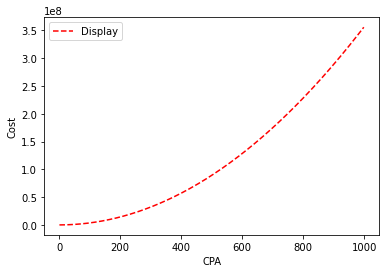

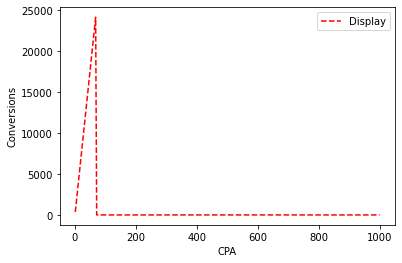

Email
Objective function y = 0.60065 * sqrt(x) + 0.00000 * log(x) + 0.00904 * x + 0.00000


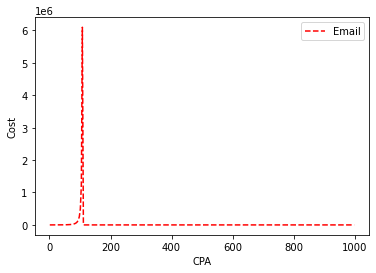

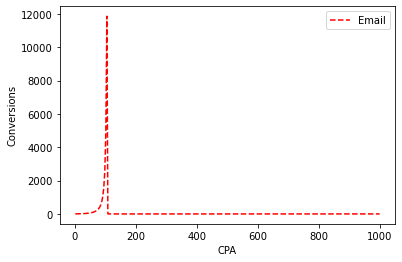

Job Posting
Objective function y = 121.31402 * sqrt(x) + 0.00000 * log(x) + 0.00000 * x + 0.00000


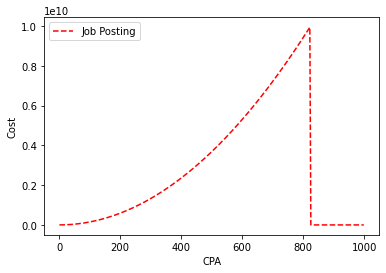

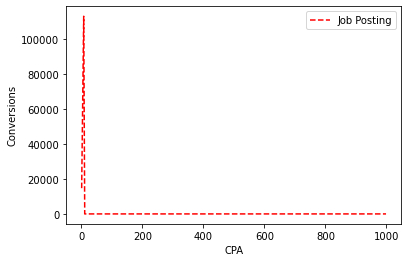

Other
Objective function y = 1.94913 * sqrt(x) + 13.86501 * log(x) + 0.00000 * x + 0.00000


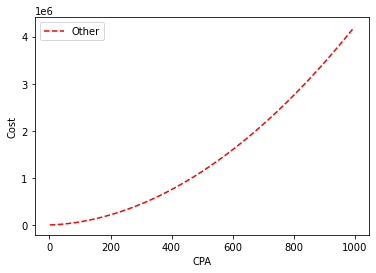

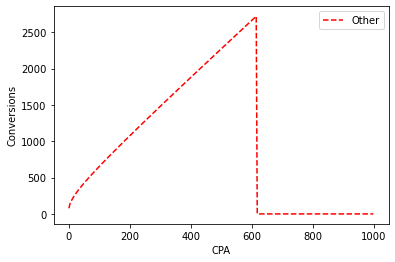

Paid Search
Objective function y = 44.31222 * sqrt(x) + 0.00000 * log(x) + 0.00000 * x + 0.00000


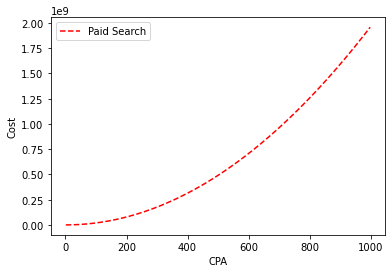

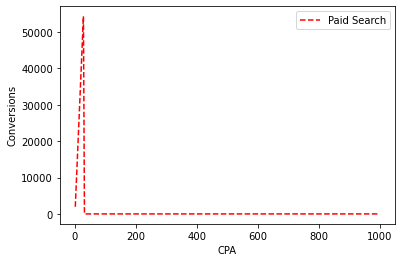

Programmatic Jobs
Objective function y = 27.63965 * sqrt(x) + 0.00000 * log(x) + 0.02053 * x + 0.00000


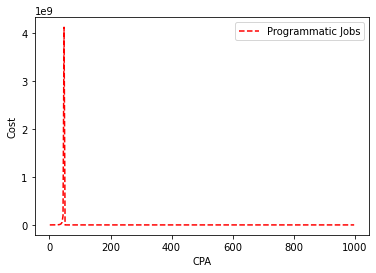

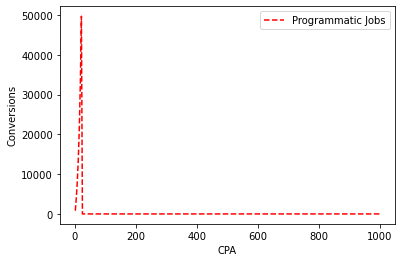

Social
Objective function y = 1.37144 * sqrt(x) + 0.71259 * log(x) + 0.00000 * x + 0.00000


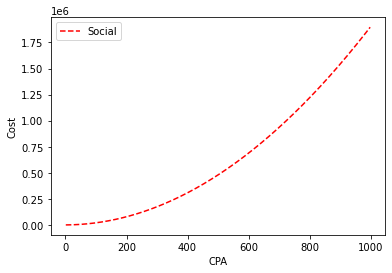

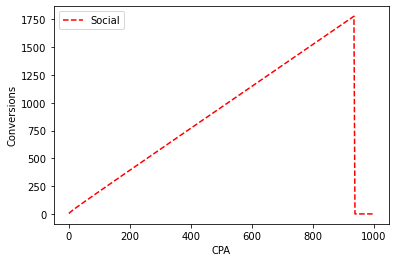

In [174]:
#the_max = 1000
for k in range(0,len(list(objective_values.keys()))):
    print(list(objective_values.keys())[k])
    print('Objective function y = %.5f * sqrt(x) + %.5f * log(x) + %.5f * x + %.5f' % (a_list[k], b_list[k], c_list[k], d_list[k]))
    x_line = np.arange(1, the_max_cpa, (the_max_cpa - 1) / 300)
    # calculate the output for the range
    y_line = [cpa_to_cost_apps(x, a_list[k], b_list[k], c_list[k], d_list[k], cost_max = 1E10)[0] for x in x_line]
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color='red', label = list(objective_values.keys())[k])
    plt.xlabel('CPA')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()
    x_line = np.arange(1, the_max_cpa, (the_max_cpa - 1) / 300)
    # calculate the output for the range
    y_line = [cpa_to_cost_apps(x, a_list[k], b_list[k], c_list[k], d_list[k])[1] for x in x_line]
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color='red', label = list(objective_values.keys())[k])
    plt.xlabel('CPA')
    plt.ylabel('Conversions')
    plt.legend()
    plt.show()

In [193]:
ans = cpa_solver(100000, cpa_min = 0, cpa_max = 100, cost_min = 0, cost_max = 1E9, cpa_tol = 1E-5, cost_tol = 1E-5, max_iter = 2000)
print(ans)

inital bounds


0

100

Final cost interval lengths 0.09361779120808933
used 24 iterations
FINAL Current total: 99999.90638220879 & 99.99990638220878% & lower bound 2.3615658283233643 upper bound 2.361571788787842 cur cpa 2.361568808555603


99999.90638220879

2.3615658283233643

2.361571788787842

{'Display': {'Cost': 1989.5960576832294, 'Apps': 842.4861016858943}, 'Email': {'Cost': 2.100790652548312, 'Apps': 0.8895723623563383}, 'Job Posting': {'Cost': 82077.45850086212, 'Apps': 34755.45200839158}, 'Other': {'Cost': 254.9204509705305, 'Apps': 107.94564616256302}, 'Paid Search': {'Cost': 10950.840078294277, 'Apps': 4637.1085487630435}, 'Programmatic Jobs': {'Cost': 4705.856554210186, 'Apps': 1992.6744295860178}, 'Social': {'Cost': 19.133949535898864, 'Apps': 8.102195788054189}, 'cpa': 2.361568808555603}


In [194]:
total_cost = 0
for key in ans.keys():
    if key != 'cpa':
        total_cost+=ans[key]['Cost']
for key in ans.keys():
    if key !='cpa':
        print(f"{key}: {round(100 * ans[key]['Cost'] / total_cost,2)}%")

Display: 1.99%
Email: 0.0%
Job Posting: 82.08%
Other: 0.25%
Paid Search: 10.95%
Programmatic Jobs: 4.71%
Social: 0.02%


In [24]:
display(ans)

{'Display': {'Cost': 199.07747628167272, 'Apps': 266.49640356501516},
 'Email': {'Cost': 0.20406787371030086, 'Apps': 0.27318078519972916},
 'Job Posting': {'Cost': 8212.40246295929, 'Apps': 10993.756238379327},
 'Other': {'Cost': 51.175447879359126, 'Apps': 68.5059333257234},
 'Paid Search': {'Cost': 1095.759216696024, 'Apps': 1466.8344799838253},
 'Programmatic Jobs': {'Cost': 439.7006705403328, 'Apps': 588.6043080722968},
 'Social': {'Cost': 1.3505996321327984, 'Apps': 1.8079951236160285},
 'cpa': 0.7470152382925153}